<a href="https://colab.research.google.com/github/h-razu/deepfake-detection/blob/main/deepfake_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the Environment

#### Download Required Library

In [1]:
!pip install opencv-python insightface onnxruntime-gpu timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s

#### Import Required Library

In [2]:
import random
import shutil
import sys
import os
import glob

import pandas as pd
from collections import Counter
from pathlib import Path

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

#### Check the Version of Library

In [3]:

print("Platform:", sys.platform)
print("Python version:", sys.version)
print("==============================")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version : ", PIL.__version__)
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version :  11.2.1
CV2 version :  4.12.0
torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124


#### Check GPU Availability

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


#### Mounting Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

#### Download FaceForensics Dataset

In [ ]:
%%writefile faceforensics_download.py

#!/usr/bin/env python
""" Downloads FaceForensics++ and Deep Fake Detection public data release
Example usage:
    see -h or https://github.com/ondyari/FaceForensics
"""
# -*- coding: utf-8 -*-
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join


# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original_youtube_videos': 'misc/downloaded_youtube_videos.zip',
    'original_youtube_videos_info': 'misc/downloaded_youtube_videos_info.zip',
    'original': 'original_sequences/youtube',
    'DeepFakeDetection_original': 'original_sequences/actors',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'DeepFakeDetection': 'manipulated_sequences/DeepFakeDetection',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceShifter': 'manipulated_sequences/FaceShifter',
    'FaceSwap': 'manipulated_sequences/FaceSwap',
    'NeuralTextures': 'manipulated_sequences/NeuralTextures'
    }
ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
                'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
                'NeuralTextures']
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-d', '--dataset', type=str, default='all',
                        help='Which dataset to download, either pristine or '
                             'manipulated data or the downloaded youtube '
                             'videos.',
                        choices=list(DATASETS.keys()) + ['all']
                        )
    parser.add_argument('-c', '--compression', type=str, default='raw',
                        help='Which compression degree. All videos '
                             'have been generated with h264 with a varying '
                             'codec. Raw (c0) videos are lossless compressed.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type, i.e. videos, masks, for our '
                             'manipulation methods, models, for Deepfakes.',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=None,
                        help='Select a number of videos number to '
                             "download if you don't want to download the full"
                             ' dataset.')
    parser.add_argument('--server', type=str, default='EU',
                        help='Server to download the data from. If you '
                             'encounter a slow download speed, consider '
                             'changing the server.',
                        choices=SERVERS
                        )
    args = parser.parse_args()

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        if report_progress:
            urllib.request.urlretrieve(url, out_file_tmp,
                                       reporthook=reporthook)
        else:
            urllib.request.urlretrieve(url, out_file_tmp)
        os.rename(out_file_tmp, out_file)
    else:
        tqdm.write('WARNING: skipping download of existing file ' + out_file)


def main(args):
    # TOS
    print('By pressing any key to continue you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')
    print('Press any key to continue, or CTRL-C to exit.')
    _ = input('')

    # Extract arguments
    c_datasets = [args.dataset] if args.dataset != 'all' else ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            # Here we download the original youtube videos zip file
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
                suffix = 'info'
                download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists and video lenghts list from server
        if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
            filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
            if 'actors' in dataset_path:
                filelist = filepaths['actors']
            else:
                filelist = filepaths['DeepFakesDetection']
        elif 'original' in dataset_path:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            filelist = []
            for pair in file_pairs:
                filelist += pair
        else:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            # Get filelist
            filelist = []
            for pair in file_pairs:
                filelist.append('_'.join(pair))
                if c_type != 'models':
                    filelist.append('_'.join(pair[::-1]))

        # Maybe limit number of videos for download
        if num_videos is not None and num_videos > 0:
            print('Downloading the first {} videos'.format(num_videos))
            filelist = filelist[:num_videos]

        # Server and local paths
            dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
            dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)

        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                if args.dataset != 'all':
                    print('Only videos available for original data. Aborting.')
                    return
                else:
                    print('Only videos available for original data. '
                          'Skipping original.\n')
                    continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)

        # Else: models for deepfakes
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            # Get Deepfakes models
            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES

                # Folder paths
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)   # already done


if __name__ == "__main__":
    args = parse_args()
    main(args)


Writing faceforensics_download.py


In [ ]:
output_path = '/content/drive/MyDrive/dataset/faceforensics'

In [ ]:
import shutil
import os

os.makedirs(output_path, exist_ok=True)
# Remove existing dataset folder (if any)
if os.path.exists(output_path):
    print(f"Deleting existing folder: {output_path}")
    shutil.rmtree(output_path)

# Recreate a clean folder
os.makedirs(output_path, exist_ok=True)

Deleting existing folder: /content/drive/MyDrive/dataset/faceforensics


In [ ]:
# download `original` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d original \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/original_sequences/youtube/raw/videos
100% 1/1 [00:26<00:00, 26.15s/it]


In [ ]:
# download `Face2Face` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d Face2Face \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/Face2Face/raw/videos
100% 1/1 [00:40<00:00, 40.23s/it]


In [ ]:
# download `FaceSwap` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d FaceSwap \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/FaceSwap/raw/videos
100% 1/1 [00:28<00:00, 28.93s/it]


In [ ]:
# download `Deepfakes` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d Deepfakes \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/Deepfakes/raw/videos
100% 1/1 [00:22<00:00, 22.36s/it]


In [ ]:
# download `NeuralTextures` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d NeuralTextures \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/NeuralTextures/raw/videos
100% 1/1 [01:14<00:00, 74.90s/it]


#### Accessing FaceForensics Datasets

In [7]:
%cd '/content/drive/MyDrive/dataset/'

/content/drive/MyDrive/dataset


In [8]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (84.8 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [9]:
!tree faceforensics --filelimit=10

faceforensics
├── manipulated_sequences
│   ├── Deepfakes
│   │   └── raw
│   │       └── videos  [50 entries exceeds filelimit, not opening dir]
│   ├── Face2Face
│   │   └── raw
│   │       └── videos  [50 entries exceeds filelimit, not opening dir]
│   ├── FaceSwap
│   │   └── raw
│   │       └── videos  [50 entries exceeds filelimit, not opening dir]
│   └── NeuralTextures
│       └── raw
│           └── videos  [50 entries exceeds filelimit, not opening dir]
└── original_sequences
    └── youtube
        └── raw
            └── videos  [50 entries exceeds filelimit, not opening dir]

17 directories, 0 files


## Preprocessing

In [3]:
%cd /content/

/content


#### Frame Extraction, Face Detection and Cropping

##### MTCNN

In [ ]:
# %%writefile deepfake_preprocessor.py

# import os
# import cv2
# import numpy as np
# from mtcnn.mtcnn import MTCNN
# from pathlib import Path

# class DeepfakePreprocessor:
#     def __init__(self, base_input_dir, base_output_dir, frame_interval=5, target_size=(224, 224)):
#         self.base_input_dir = base_input_dir
#         self.base_output_dir = base_output_dir
#         self.frame_interval = frame_interval
#         self.target_size = target_size
#         self.detector = MTCNN()

#         self.fake_sources = [
#             "manipulated_sequences/Deepfakes/c23/videos",
#             "manipulated_sequences/Face2Face/c23/videos",
#             "manipulated_sequences/FaceSwap/c23/videos",
#             "manipulated_sequences/NeuralTextures/c23/videos"
#         ]
#         self.real_source = "original_sequences/youtube/c23/videos"

#     def extract_faces_from_video(self, video_path, save_dir):
#         cap = cv2.VideoCapture(str(video_path))
#         frame_idx = 0
#         saved_idx = 0

#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             if frame_idx % self.frame_interval == 0:
#                 rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#                 faces = self.detector.detect_faces(rgb_frame)

#                 for face in faces:
#                     x, y, w, h = face['box']
#                     x, y = max(0, x), max(0, y)
#                     face_crop = rgb_frame[y:y+h, x:x+w]
#                     face_resized = cv2.resize(face_crop, self.target_size)
#                     os.makedirs(save_dir, exist_ok=True)
#                     save_path = os.path.join(save_dir, f"frame_{saved_idx:05d}.jpg")
#                     cv2.imwrite(save_path, cv2.cvtColor(face_resized, cv2.COLOR_RGB2BGR))
#                     saved_idx += 1
#                     break  # only save one face per frame

#             frame_idx += 1

#         cap.release()

#     def process_folder(self, input_folder, label):
#         video_files = list(Path(input_folder).glob("*.mp4"))
#         print(f"\nProcessing {label.upper()} set from: {input_folder} ({len(video_files)} videos)")

#         for video_file in video_files:
#             video_name = video_file.stem
#             output_dir = os.path.join(self.base_output_dir, label, video_name)
#             if not os.path.exists(output_dir) or len(os.listdir(output_dir)) == 0:
#                 print(f" → Extracting {video_name}")
#                 self.extract_faces_from_video(video_file, output_dir)
#             else:
#                 print(f" → Skipping {video_name} (already processed)")

#     def run(self):
#         # Process real videos
#         real_path = os.path.join(self.base_input_dir, self.real_source)
#         self.process_folder(real_path, "real")

#         # Process all fake videos
#         for fake_rel_path in self.fake_sources:
#             fake_path = os.path.join(self.base_input_dir, fake_rel_path)
#             self.process_folder(fake_path, "fake")


Writing deepfake_preprocessor.py


In [ ]:
# from deepfake_preprocessor import DeepfakePreprocessor

# # Set input/output paths
# input_dir = '/content/drive/MyDrive/dataset/faceforensics'
# output_dir = '/content/drive/MyDrive/dataset/processed'

# # Initialize and run the preprocessor
# preprocessor = DeepfakePreprocessor(input_dir, output_dir)
# preprocessor.run()

##### RetinaFace

Performed **`frame extraction`** from each video by sampling every 5th frame to reduce redundancy and ensure manageable processing. Then, I used **`RetinaFace`**, a GPU-accelerated face detector, to locate and crop the most prominent face from each sampled frame. This step isolates the facial region, which is the primary area manipulated in deepfake videos. The cropped faces were resized and saved for training a deep learning model. This preprocessing ensures consistent input quality and focuses the model on the most relevant visual features for accurate deepfake detection.


In [11]:
%%writefile retina_face_extraction.py

import os
import cv2
import numpy as np
from pathlib import Path
from insightface.app import FaceAnalysis
from tqdm import tqdm

app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0)  # 0 = first GPU

class RetinaFacePreprocessor:
    def __init__(self, base_input_dir, base_output_dir, frame_count=10, target_size=(224, 224)):
        self.base_input_dir = base_input_dir
        self.base_output_dir = base_output_dir
        self.frame_count = frame_count
        self.target_size = target_size

        # Initialize RetinaFace with GPU support
        self.face_analyzer = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
        self.face_analyzer.prepare(ctx_id=0)

        self.fake_sources = [
            "manipulated_sequences/Deepfakes/raw/videos",
            "manipulated_sequences/Face2Face/raw/videos",
            "manipulated_sequences/FaceSwap/raw/videos",
            "manipulated_sequences/NeuralTextures/raw/videos"
        ]
        self.real_source = "original_sequences/youtube/raw/videos"

    def extract_faces_from_video(self, video_path, save_dir):
        cap = cv2.VideoCapture(str(video_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        step = max(total_frames // self.frame_count, 1)
        saved_count = 0

        for i in range(self.frame_count):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if not ret:
                continue

            faces = self.face_analyzer.get(frame)
            if faces:
                # Get the first face detected
                box = faces[0].bbox.astype(int)
                x1, y1, x2, y2 = np.clip(box, 0, None)
                face_crop = frame[y1:y2, x1:x2]
                if face_crop.size == 0:
                    continue
                face_resized = cv2.resize(face_crop, self.target_size)

                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f"frame_{saved_count:05d}.jpg")
                cv2.imwrite(save_path, face_resized)
                saved_count += 1

            if saved_count >= self.frame_count:
                break

        cap.release()

    def process_folder(self, input_folder, label):
        video_files = list(Path(input_folder).glob("*.mp4"))
        print(f"\nProcessing {label.upper()} from {input_folder} ({len(video_files)} videos)")

        for video_file in tqdm(video_files):
            video_name = video_file.stem
            output_dir = os.path.join(self.base_output_dir, label, video_name)
            if not os.path.exists(output_dir) or len(os.listdir(output_dir)) < self.frame_count:
                self.extract_faces_from_video(video_file, output_dir)

    def run(self):
        # Process real videos
        self.process_folder(os.path.join(self.base_input_dir, self.real_source), "real")

        # Process fake videos
        for fake_rel_path in self.fake_sources:
            method_name = fake_rel_path.split("/")[1]  # Deepfakes, Face2Face, etc.
            label_path = os.path.join("fake", method_name)
            full_input_path = os.path.join(self.base_input_dir, fake_rel_path)
            self.process_folder(full_input_path, label_path)

Writing retina_face_extraction.py


In [12]:
from retina_face_extraction import RetinaFacePreprocessor

# Set input/output paths
input_dir = '/content/drive/MyDrive/dataset/faceforensics'
output_dir = '/content/drive/MyDrive/dataset/processed'

if os.path.exists(output_dir):
        print(f"Clearing existing folder: {output_dir}")
        shutil.rmtree(output_dir)  # Deletes the folder and all its contents
        os.makedirs(output_dir)    # Recreate the empty folder
        print("Folder cleared and recreated.")

# Initialize and run the preprocessor
processor = RetinaFacePreprocessor(input_dir, output_dir)
processor.run()

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 45623.16KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

100%|██████████| 50/50 [15:41<00:00, 18.83s/it]



Processing FAKE/DEEPFAKES from /content/drive/MyDrive/dataset/faceforensics/manipulated_sequences/Deepfakes/raw/videos (50 videos)


100%|██████████| 50/50 [15:58<00:00, 19.17s/it]



Processing FAKE/FACE2FACE from /content/drive/MyDrive/dataset/faceforensics/manipulated_sequences/Face2Face/raw/videos (50 videos)


100%|██████████| 50/50 [15:45<00:00, 18.91s/it]



Processing FAKE/FACESWAP from /content/drive/MyDrive/dataset/faceforensics/manipulated_sequences/FaceSwap/raw/videos (50 videos)


100%|██████████| 50/50 [15:44<00:00, 18.89s/it]



Processing FAKE/NEURALTEXTURES from /content/drive/MyDrive/dataset/faceforensics/manipulated_sequences/NeuralTextures/raw/videos (50 videos)


100%|██████████| 50/50 [16:35<00:00, 19.92s/it]


##### Display Sample Image

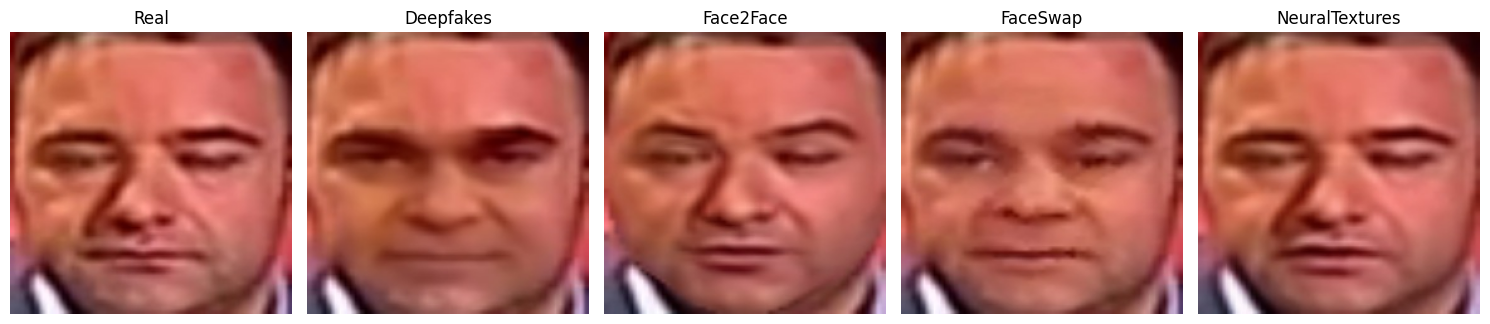

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def get_one_image_from_each_video(folder):
    """Get the first available frame from each video directory."""
    video_dirs = sorted(Path(folder).glob("*"))
    for video_dir in video_dirs:
        if video_dir.is_dir():
            frames = sorted(video_dir.glob("*.jpg"))
            if frames:
                return str(frames[0])
    return None

def display_real_vs_fakes(base_dir, fake_folders):
    images = []

    # Get one real image
    real_image_path = get_one_image_from_each_video(os.path.join(base_dir, 'real'))
    if real_image_path:
        images.append(('Real', real_image_path))

    # Get one fake image from each fake folder
    for fake_type in fake_folders:
        fake_folder_path = os.path.join(base_dir, 'fake', fake_type)
        fake_image_path = get_one_image_from_each_video(fake_folder_path)
        if fake_image_path:
            images.append((fake_type, fake_image_path))

    # Plot all images
    plt.figure(figsize=(len(images) * 3, 4))
    for i, (label, img_path) in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
base_dir = "/content/drive/MyDrive/dataset/processed"
fake_folders = ['Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures']

display_real_vs_fakes(base_dir, fake_folders)

#### Gather all image paths and assign labels

In this step, loop through the processed dataset directory to collect the file paths of all cropped face images. Each image is assigned a label — `0` for real faces and `1` for fake faces (regardless of manipulation type). These `(image_path, label)` pairs will be used to load and prepare the dataset for training and evaluation.


In [4]:
def gather_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    # Real images
    real_dir = Path(base_dir) / 'real'
    for video_folder in real_dir.glob("*"):
        for img_path in video_folder.glob("*.jpg"):
            image_paths.append(str(img_path))
            labels.append(0)  # Label 0 for real

    # Fake images
    fake_base_dir = Path(base_dir) / 'fake'
    for fake_type_dir in fake_base_dir.glob("*"):  # e.g., Deepfakes, Face2Face, etc.
        for video_folder in fake_type_dir.glob("*"):
            for img_path in video_folder.glob("*.jpg"):
                image_paths.append(str(img_path))
                labels.append(1)  # Label 1 for all fakes

    return image_paths, labels


In [5]:
base_dir = "/content/drive/MyDrive/dataset/processed"
image_paths, labels = gather_image_paths_and_labels(base_dir)

print(f"Total images collected: {len(image_paths)}")
print(f"Sample: {image_paths[0]}, Label: {labels[0]}")

Total images collected: 2500
Sample: /content/drive/MyDrive/dataset/processed/real/585/frame_00000.jpg, Label: 0


0


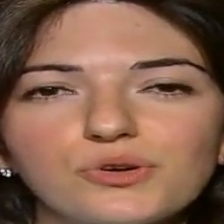

In [6]:
print(labels[1])
Image.open(image_paths[1])

#### Custom PyTorch Dataset

This custom `DeepfakeDataset` class is built to efficiently load deepfake images and their labels for training a PyTorch model. It takes image file paths and corresponding labels, loads each image in RGB format, applies optional transformations (like resizing or normalization), and returns the processed image along with its label as a tensor. This setup is essential when working with non-standard datasets, giving you full control over data loading and preprocessing while enabling seamless integration with PyTorch's `DataLoader` for efficient training.

In [7]:
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [8]:
full_dataset = DeepfakeDataset(image_paths, labels, transform=None)

#### Splitting Dataset into Train, Validation, and Test Sets

This code splits the full dataset into training, validation, and test sets using PyTorch’s `random_split` function. It divides the data into 70% for training, 15% for validation, and 15% for testing, ensuring that the split is reproducible by setting a random seed. This is important for evaluating model performance fairly and preventing data leakage between sets during deepfake model training.

In [9]:
from torch.utils.data import random_split

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Remaining

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

#### Image Transforms for Training and Evaluation

This code defines two sets of image transformations: one for training data that includes resizing, random horizontal flipping, color jittering, tensor conversion, and normalization to help the model generalize better by augmenting the images; and another simpler set for validation and test data that only resizes, converts to tensor, and normalizes. These transforms are then applied to the respective dataset splits to ensure consistent preprocessing during training and evaluation.

In [26]:
from copy import deepcopy

def get_transformed_datasets(train_dataset, val_dataset, test_dataset,
                             train_size=(224, 224), val_test_size=(224, 224)):
    train_transform = transforms.Compose([
        transforms.Resize(train_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(val_test_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Deepcopy datasets so original ones stay unchanged
    train_ds = deepcopy(train_dataset)
    val_ds = deepcopy(val_dataset)
    test_ds = deepcopy(test_dataset)

    # Apply transforms
    train_ds.transform = train_transform
    val_ds.transform = val_test_transform
    test_ds.transform = val_test_transform

    return train_ds, val_ds, test_ds

In [27]:
train_dataset_transformed, val_dataset_transformed, test_dataset_transformed = get_transformed_datasets(
    train_dataset, val_dataset, test_dataset
)

#### DataLoader Setup and Batch Retrieval

This code creates DataLoaders for the training, validation, and test datasets with a batch size of 32. The training DataLoader shuffles data to improve model learning, while validation and test loaders do not shuffle to maintain consistency during evaluation. It also demonstrates how to retrieve and inspect one batch of images and labels from the training DataLoader.

In [23]:
def prepare_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32, shuffle_train=True):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get one batch from the training loader
    sample_images, sample_labels = next(iter(train_loader))
    print(f"Train batch - images: {sample_images.shape}, labels: {sample_labels.shape}")

    return train_loader, val_loader, test_loader, sample_images, sample_labels


In [28]:
train_loader, val_loader, test_loader, images, labels = prepare_dataloaders(
    train_dataset_transformed, val_dataset_transformed, test_dataset_transformed, batch_size=64
)

Train batch - images: torch.Size([64, 3, 224, 224]), labels: torch.Size([64])


## Pretrained Model: XceptionNet

#### Load Pretrained XceptionNet

In [12]:
import timm

# Load XceptionNet from timm
model = timm.create_model('xception', pretrained=True)

# Modify the classifier for binary classification (real vs fake)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


#### Define Loss, Optimizer & Scheduler

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#### Training Loop

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/10], Loss: 21.3976
Epoch [2/10], Loss: 4.1265
Epoch [3/10], Loss: 1.7404
Epoch [4/10], Loss: 1.5468
Epoch [5/10], Loss: 1.2006
Epoch [6/10], Loss: 0.6321
Epoch [7/10], Loss: 0.3555
Epoch [8/10], Loss: 0.3539
Epoch [9/10], Loss: 0.3239
Epoch [10/10], Loss: 0.3181


#### Evaluate on Validation and Training Set

In [20]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Check training and validation accuracy
train_acc = evaluate_model(model, train_loader, device)
val_acc = evaluate_model(model, val_loader, device)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy: 0.9977
Validation Accuracy: 0.9920


#### Evaluate on Test Set and Confusion Matrix

Test Accuracy: 0.9893


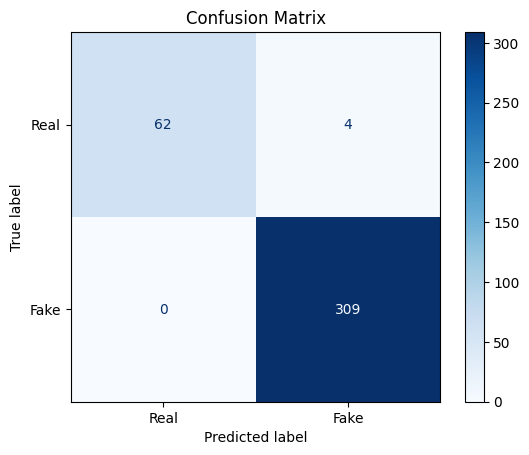

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate on test set
test_acc = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
def plot_conf_matrix(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

plot_conf_matrix(model, test_loader, device)